In [1]:
import cebra
import c3d
from cebra import CEBRA
import cebra.models
import os
from scipy import stats
import tempfile
from pathlib import Path
import torch
from torch import nn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import rgb2hex
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import sys
sys.path.append('../../../')
from dataset_load import data_load
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from PIL import Image 
from cebra.models.model import _OffsetModel, ConvolutionalModelMixin
from matplotlib.colors import ListedColormap

In [2]:
@cebra.models.register("offset200-model") # --> add that line to register the model!
class Offset200Model(_OffsetModel, ConvolutionalModelMixin):

    def __init__(self, num_neurons, num_units, num_output, normalize=True):
        super().__init__(
            
            nn.Conv1d(num_neurons, num_units, 101),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_output, 20),
            num_input=num_neurons,
            num_output=num_output,
            normalize=normalize,
        )

    # ... and you can also redefine the forward method,
    # as you would for a typical pytorch model

    def get_offset(self) -> cebra.data.datatypes.Offset:
        return cebra.data.Offset(100, 100)

In [3]:


colors = ["cyan", "#2e2d4d", "m"]
colors = ["cyan", "#55538d", "m"]

cmap = ListedColormap(colors)

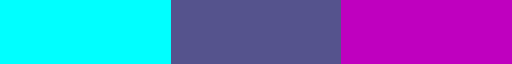

In [4]:
cmap

In [5]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]

In [6]:
def import_c3d(path):
    """
    Fills df from c3d file

    :param path: path to .c3d
    :return: first_frame, last_frame, sample_rate, df
    """
    with open(path, "rb") as f:
        c3d_reader = c3d.Reader(f)
        first_frame = c3d_reader._header.first_frame
        last_frame = c3d_reader._header.last_frame
        sample_rate = c3d_reader._header.frame_rate

    return first_frame, last_frame, sample_rate

In [7]:
data = import_c3d(f"{input_folder}230330/NWE00130/12/runway12.c3d")

In [8]:
data

(1921, 14480, 200.0)

In [9]:
def animal_to_number(animal_list):
    unique = np.unique(animal_list)
    number_dict = dict()
    number_list = []
    count = 0
    for a in unique:
        number_dict[a] = count
        count+=1
    for a in animal_list:
        number_list.append(number_dict[a])
    return np.asarray(number_list)

In [10]:
data_dict = data_load(input_folder, variables_to_drop, skipdates)


No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [11]:
x_pd = data_dict["X_pd"].reset_index(drop=True)
y_pd = data_dict["y_pd"]
animals_id_pd = data_dict["animals_id_pd"]
run_id_pd = data_dict["run_id_pd"]

x_h = data_dict["X_h"].reset_index(drop=True)
y_h = data_dict["y_h"]
animals_id_h = data_dict["animals_id_h"]

train_indices, test_indices = train_test_split(x_pd.index, test_size=0.2, shuffle=True, random_state=42)

# Sort the indices to maintain chronological order
train_indices_sorted = sorted(train_indices)
test_indices_sorted = sorted(test_indices)

# Create the train and test sets
X_train = x_pd.iloc[train_indices_sorted]
X_test = x_pd.iloc[test_indices_sorted]
y_train = y_pd[train_indices_sorted]
y_test = y_pd[test_indices_sorted]
animal_train = animals_id_pd[train_indices_sorted]
run_id_train = run_id_pd[train_indices_sorted]

In [12]:

loaded_cebra_model = cebra.CEBRA.load("../full_run/models/neural_full_pd.pt")

In [13]:
embedding = loaded_cebra_model.transform(x_pd.iloc[:, 36:])

In [14]:
x_df = pd.DataFrame(embedding, columns=["emb1", "emb2", "emb3"])
x_df["animal"] = animals_id_pd
x_df["run"] = run_id_pd
x_df["label"] = y_pd

In [15]:
animal = "NWE00130"
run = "230330.012.0"

x_run = x_df[(x_df["animal"]==animal) & (x_df["run"]==run)]

y_run = x_run["label"]
x_run = x_run.drop(["animal", "run", "label"], axis=1)
run_embedding = x_run[["emb1", "emb2", "emb3"]].values
#x_run.reset_index(drop=True, inplace=True)

In [17]:
folder = "frames_neural_only"

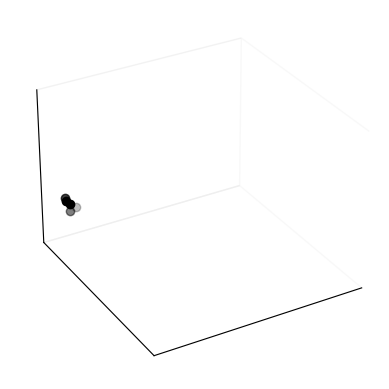

In [20]:

# folde = "frames_decim"
x = run_embedding[::10, 0]
y = run_embedding[::10, 1]
z = run_embedding[::10, 2]

# Set up the figure and 3D axis with a transparent background
fig = plt.figure()
fig.patch.set_alpha(0)  # Set figure background to transparent
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor((0, 0, 0, 0))  # Set axis background to transparent

# Axis limits
ax.set_xlim((min(x), max(x)))
ax.set_ylim((min(y), max(y)))
ax.set_zlim((min(z), max(z)))

# Disable grids, tick marks, labels, and pane colors
ax.grid(False)  # Turn off grid lines
ax.set_xticks([])  # Remove x ticks
ax.set_yticks([])  # Remove y ticks
ax.set_zticks([])  # Remove z ticks
ax.set_xlabel('')   # Remove x label
ax.set_ylabel('')   # Remove y label
ax.set_zlabel('')   # Remove z label

# Remove panes (walls)
ax.xaxis.pane.fill = False  # Hide x-axis pane
ax.yaxis.pane.fill = False  # Hide y-axis pane
ax.zaxis.pane.fill = False  # Hide z-axis pane

# Remove pane borders
ax.xaxis._axinfo['grid'].update(color = (1,1,1,0))  # Make x-axis grid lines transparent
ax.yaxis._axinfo['grid'].update(color = (1,1,1,0))  # Make y-axis grid lines transparent
ax.zaxis._axinfo['grid'].update(color = (1,1,1,0))  # Make z-axis grid lines transparent

# Tail length and alpha settings
tail_length = 5  # Number of points in the tail
alphas = np.linspace(1, 0, tail_length)  # Alpha values from 1 to 0.1

# Directory to save frames
if not os.path.exists("frames"):
    os.makedirs("frames")

def update(frame):
    # Clear the axis to remove previous points
    ax.cla()

    # Keep the transparent settings and limits
    ax.set_xlim((max(x), min(x)))
    ax.set_ylim((min(y), max(y)))
    ax.set_zlim((min(z), max(z)))
    ax.set_xticks([])  # Remove x ticks
    ax.set_yticks([])  # Remove y ticks
    ax.set_zticks([])  # Remove z ticks
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis._axinfo['grid'].update(color = (1,1,1,0))
    ax.yaxis._axinfo['grid'].update(color = (1,1,1,0))
    ax.zaxis._axinfo['grid'].update(color = (1,1,1,0))
    ax.azim = -120

    # Plot the main point
    ax.plot([x[frame]], [y[frame]], [z[frame]], 'ko')

    # Plot the tail with fading effect
    for i in range(1, tail_length + 1):
        if frame - i >= 0:  # Ensure we're within bounds
            ax.plot([x[frame - i]], [y[frame - i]], [z[frame - i]], 
                    'ko', alpha=alphas[i - 1])

    # Save the current frame as a PNG
    zeros = 4 - len(str(frame)) + 1
    zeros = "0"*zeros
    fig.savefig(f"{folder}/frame_{zeros}{frame}.png", transparent=True)

# Generate each frame
for i in range(len(x)):
    update(i)
#frames[0].save("3d_point_movement_transparent.gif", save_all=True, append_images=frames[1:], duration=100, loop=0, transparency=0)

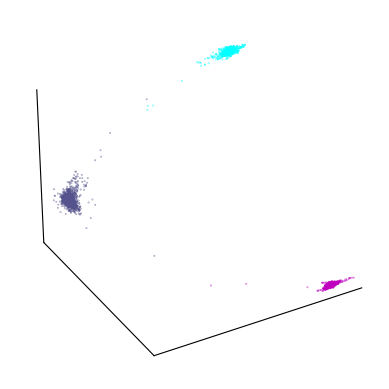

In [21]:

ax = cebra.plot_embedding(embedding=run_embedding, embedding_labels=y_run, title="", alpha=1, cmap=cmap)
ax.set_xlim((max(x), min(x)))
ax.set_ylim((min(y), max(y)))
ax.set_zlim((min(z), max(z)))

ax.get_zlim()

ax.xaxis.pane.fill = False  # Hide x-axis pane
ax.yaxis.pane.fill = False  # Hide y-axis pane
ax.zaxis.pane.fill = False  # Hide z-axis pane
ax.azim = -120


ax.grid(False)
ax.set_xticks([])  # Remove x ticks
ax.set_yticks([])  # Remove y ticks
ax.set_zticks([])  # Remove z ticks
ax.set_xlabel('')   # Remove x label
ax.set_ylabel('')   # Remove y label
ax.set_zlabel('')   # Remove z label

fig = plt.gcf()
size = fig.get_size_inches()*fig.dpi
fig.set_size_inches(6.4, 4.8)
plt.savefig(f"{folder}/e.png")